In [11]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)

This took  163.09139895439148 s


In [4]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

In [5]:
# standardize input
clusters_t = mf.standardscore(clusters_t)
clusters_v = mf.standardscore(clusters_v)

In [7]:
model1 = keras.models.load_model('stage2model_corr_standardization')
model1.summary()
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1664      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

In [8]:
output = model1.predict(clusters_v)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

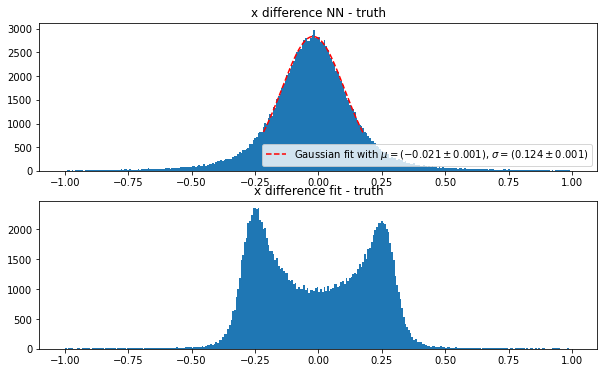

In [19]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=True)

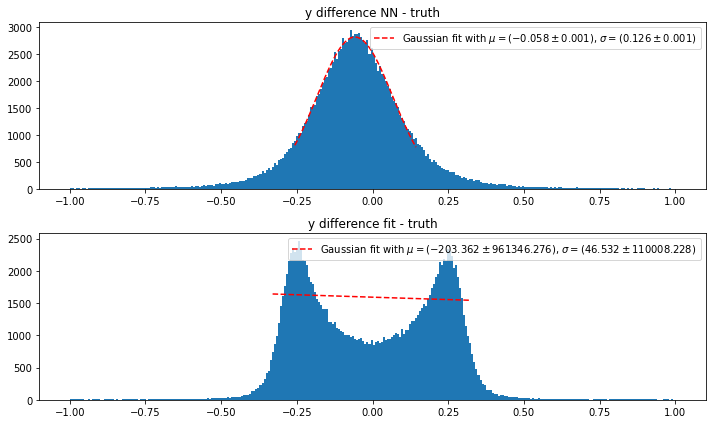

(array([-5.83734193e-02,  1.25736079e-01,  8.86787341e+02]),
 array([8.50681118e-04, 1.12151635e-03, 6.36646946e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [10]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

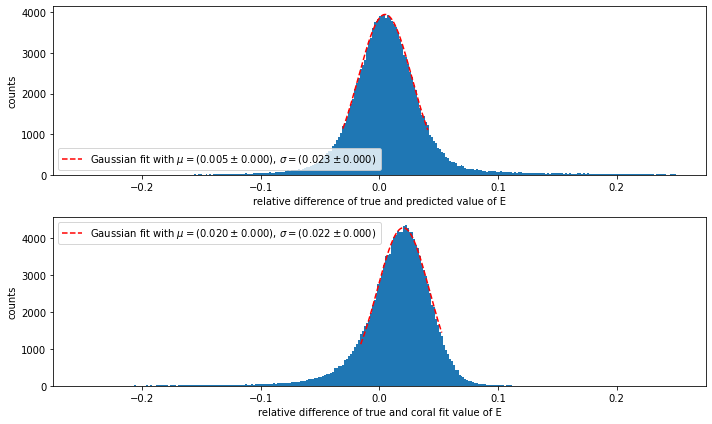

In [14]:
E_bad = mf.histo_output_rel(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-0.25,0.25), fit=True)

<h3> Crosscheck </h3>

The x, y positions that lay one $\sigma$ away should intuitively be the ones with lower energies. Let's crosscheck this.

In [20]:
def histo_output_crosscheck(xy_NN, xy_truth, E_truth, name='', range_x = (-0.25,0.25), bins=300, num_sig=1):
    '''similar to histo_output but written for E to show how well NN works for differnet energies. Display relative difference and return values that are more than "num_sig" times sigma away'''
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(1,1,1)
    n_counts, bins, patches = plt.hist((xy_NN-xy_truth)/xy_truth, bins=bins, range=range_x)
    
    # fit
    maxv = n_counts.max()
    ind_fit = np.where(n_counts > 0.3*maxv)
    liml = ind_fit[0].min()
    limu = ind_fit[0].max() + 1

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of " + name)
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((xy_NN-xy_truth)/xy_truth) > num_sig * popt1[1]) # all events further away than 1 sigma
    values_bad_xy = xy_truth[ind_bad]
    E_bad = E_truth[ind_bad]
    
    plt.tight_layout()
    plt.show()
    
    return values_bad_xy, E_bad # return values that are more than 1 (num_sig) sigma away

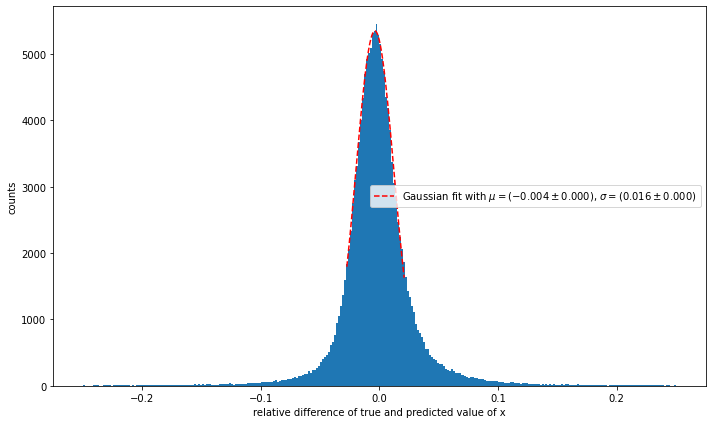

In [22]:
xy_bad, E_bad = histo_output_crosscheck(output.T[0], veri_truth_data.T[0], veri_truth_data.T[2], name="x")

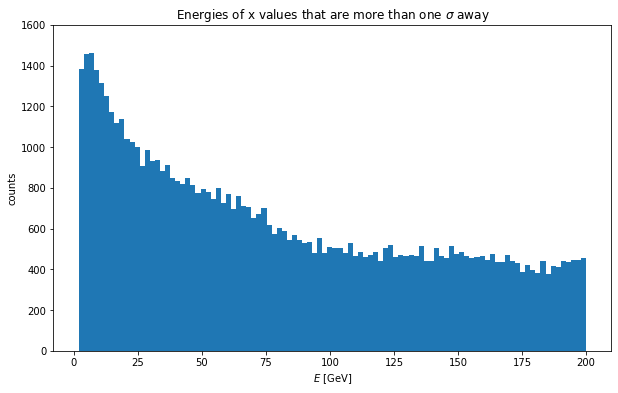

In [48]:
plt.hist(E_bad, bins=100)
plt.title("Energies of x values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.ylim(0, 1600)
plt.show()

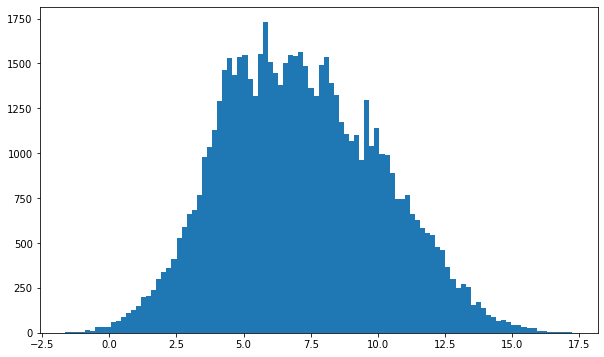

In [30]:
plt.hist(xy_bad, bins=100)
plt.show()

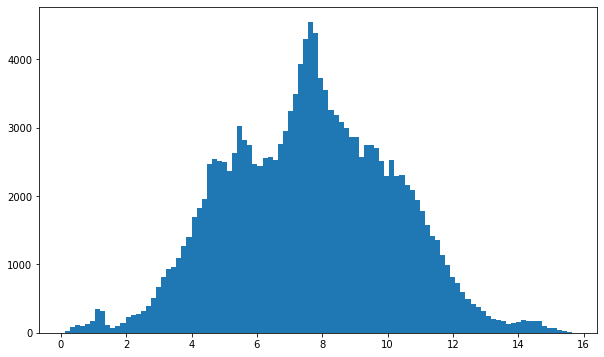

In [37]:
plt.hist(output.T[0], bins=100)
plt.show()

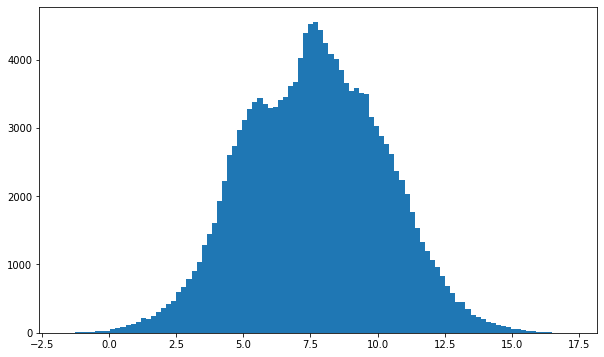

In [35]:
plt.hist(veri_truth_data.T[0], bins=100)
plt.show()

and for y...

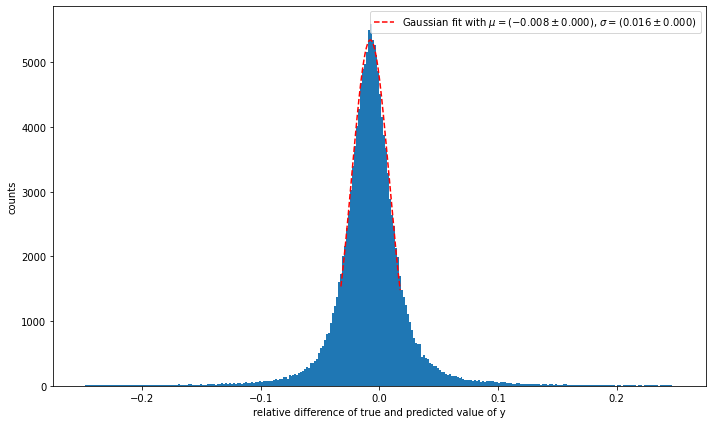

In [39]:
y_bad, Ey_bad = histo_output_crosscheck(output.T[1], veri_truth_data.T[1], veri_truth_data.T[2], name="y")

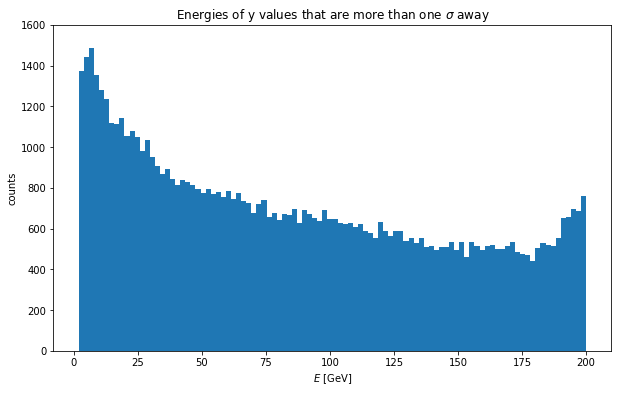

In [47]:
plt.hist(Ey_bad, bins=100)
plt.title("Energies of y values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.ylim(0, 1600)
plt.show()

<h3> Is this different for random placing the clusters...?

In [41]:
model2 = keras.models.load_model('stage2model_corr_standardization_randomzeros')
model2.summary()
model2.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 9

In [42]:
output2 = model2.predict(clusters_v)

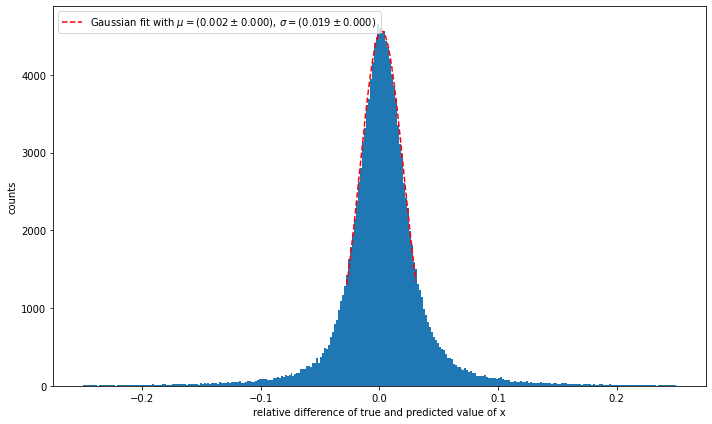

In [43]:
x_bad2, Ex_bad2 = histo_output_crosscheck(output2.T[0], veri_truth_data.T[0], veri_truth_data.T[2], name="x")

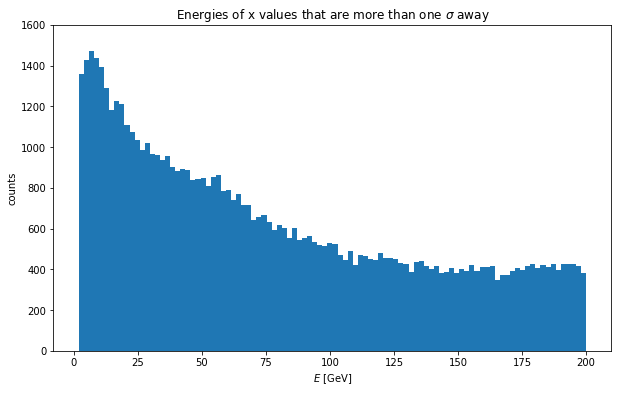

In [50]:
plt.hist(Ex_bad2, bins=100)
plt.title("Energies of x values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.ylim(0, 1600)
plt.show()

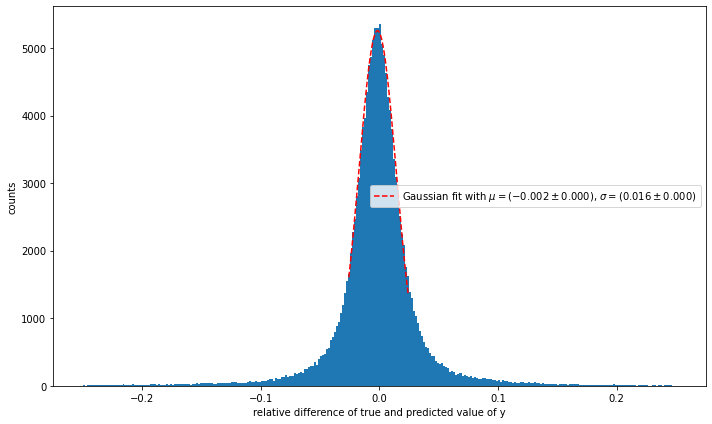

In [45]:
y_bad2, Ey_bad2 = histo_output_crosscheck(output2.T[1], veri_truth_data.T[1], veri_truth_data.T[2], name="y")

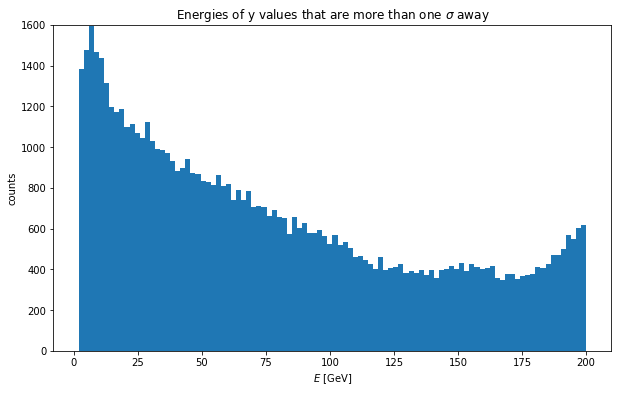

In [49]:
plt.hist(Ey_bad2, bins=100)
plt.title("Energies of y values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.ylim(0, 1600)
plt.show()

<h2> Comparison

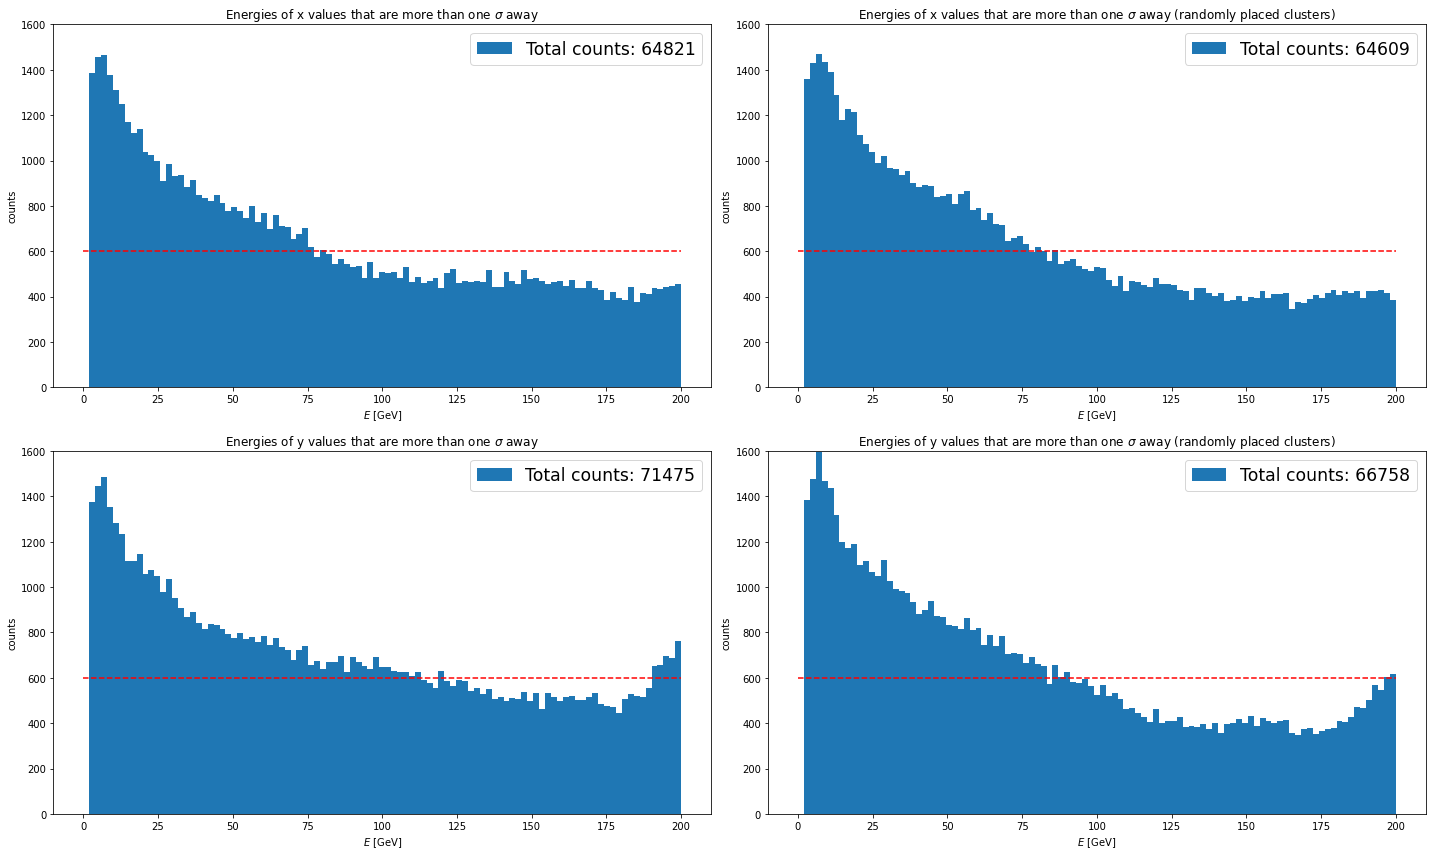

In [72]:
plt.rcParams["figure.figsize"] = (20,12)

plt.subplot(2,2,1)
plt.hist(E_bad, bins=100, label="Total counts: "+ str(len(E_bad)))
plt.legend(fontsize="xx-large")
plt.title("Energies of x values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1600)

plt.subplot(2,2,2)
plt.hist(Ex_bad2, bins=100, label="Total counts: "+ str(len(Ex_bad2)))
plt.legend(fontsize="xx-large")
plt.title("Energies of x values that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1600)

plt.subplot(2,2,3)
plt.hist(Ey_bad, bins=100, label="Total counts: "+ str(len(Ey_bad)))
plt.legend(fontsize="xx-large")
plt.title("Energies of y values that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1600)

plt.subplot(2,2,4)
plt.hist(Ey_bad2, bins=100, label="Total counts: "+ str(len(Ey_bad2)))
plt.legend(fontsize="xx-large")
plt.title("Energies of y values that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1600)

plt.tight_layout()
plt.show()

Also have a look at the energies...

In [109]:
def histo_output_E(arr_NN, arr_truth, range_x=(-0.25,0.25), bins=300):
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(2,1,1)
    n_counts, bins, patches = plt.hist((arr_NN-arr_truth)/arr_truth, bins=bins, range=range_x)

    maxv = n_counts.max()
    ind_fit = np.where(n_counts > 0.3*maxv)
    liml = ind_fit[0].min()
    limu = ind_fit[0].max() + 1

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of E")
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((arr_NN-arr_truth)/arr_truth) > popt1[1]) # all events further away than 1 sigma
    values_bad = arr_truth[ind_bad]
    
    plt.tight_layout()
    plt.show()
    return values_bad

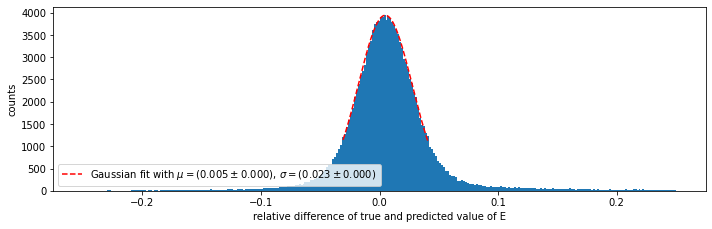

In [110]:
E_values_bad1 = histo_output_E(output.T[2], veri_truth_data.T[2])

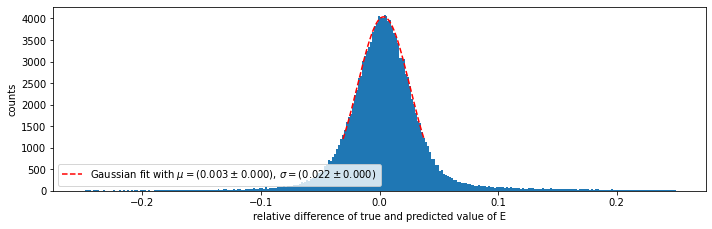

In [111]:
E_values_bad2 = histo_output_E(output2.T[2], veri_truth_data.T[2])

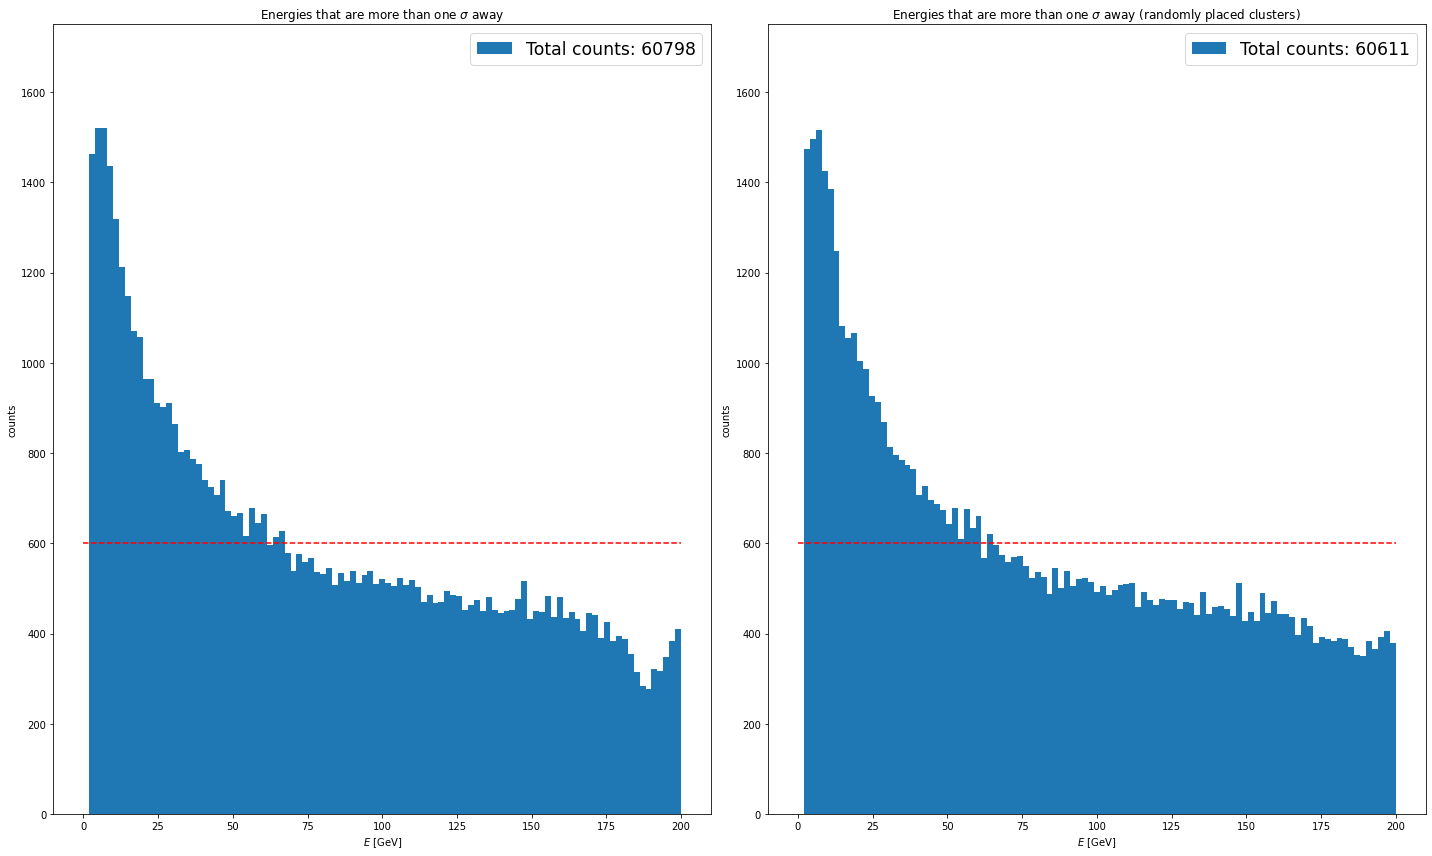

In [100]:
plt.rcParams["figure.figsize"] = (20,12)

plt.subplot(1,2,1)
plt.hist(E_values_bad1, bins=100, label="Total counts: "+ str(len(E_values_bad1)))
plt.legend(fontsize="xx-large")
plt.title("Energies that are more than one $\sigma$ away")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1750)


plt.subplot(1,2,2)
plt.hist(E_values_bad2, bins=100, label="Total counts: "+ str(len(E_values_bad2)))
plt.legend(fontsize="xx-large")
plt.title("Energies that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, 1750)

plt.tight_layout()
plt.show()

<h2> Conclusion </h2> 

**Note:** By making a mistake I realized that the network sometimes thinks that very high $E$ values are actually very low. I suspect that this is already a problem in the simulation? Why are there no big clusters? I doubt that the network is wrong.

- [ ] Why is there a peak at 200 GeV for the $y$-position but not in the $x$-position?
- [ ] How can lower energies trained better? Or is this already the best possible resolution?
- [x] The resolution of randomly and bias placed clusters was the same, so it's no surprise that the total numbers of events is approximately the same.

The red line is only there to help the eyes.


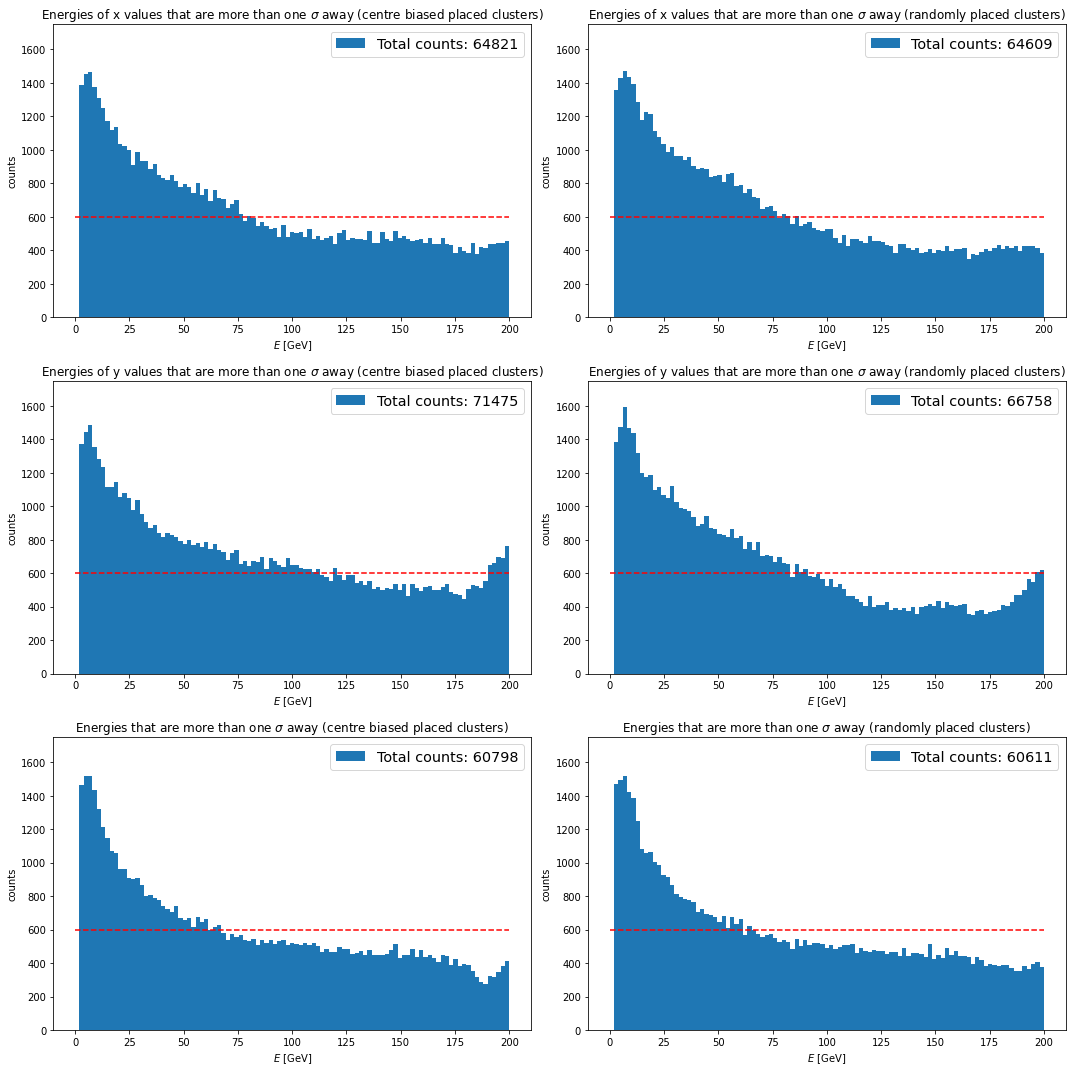

In [112]:
plt.rcParams["figure.figsize"] = (15,15)

ylim = 1750

plt.subplot(3,2,1)
plt.hist(E_bad, bins=100, label="Total counts: "+ str(len(E_bad)))
plt.legend(fontsize="x-large")
plt.title("Energies of x values that are more than one $\sigma$ away (centre biased placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(3,2,2)
plt.hist(Ex_bad2, bins=100, label="Total counts: "+ str(len(Ex_bad2)))
plt.legend(fontsize="x-large")
plt.title("Energies of x values that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(3,2,3)
plt.hist(Ey_bad, bins=100, label="Total counts: "+ str(len(Ey_bad)))
plt.legend(fontsize="x-large")
plt.title("Energies of y values that are more than one $\sigma$ away (centre biased placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(3,2,4)
plt.hist(Ey_bad2, bins=100, label="Total counts: "+ str(len(Ey_bad2)))
plt.legend(fontsize="x-large")
plt.title("Energies of y values that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(3,2,5)
plt.hist(E_values_bad1, bins=100, label="Total counts: "+ str(len(E_values_bad1)))
plt.legend(fontsize="x-large")
plt.title("Energies that are more than one $\sigma$ away (centre biased placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)


plt.subplot(3,2,6)
plt.hist(E_values_bad2, bins=100, label="Total counts: "+ str(len(E_values_bad2)))
plt.legend(fontsize="x-large")
plt.title("Energies that are more than one $\sigma$ away (randomly placed clusters)")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.tight_layout()
plt.show()